# Setting up 

In [214]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [215]:
!ls

Credit_card_default%20-%20Business%20Problem%20-%20Assessment%20Criteria%20-%20Data%20Dictionary.xlsx
credit_card_default_test.csv
credit_card_default_train.csv.zip
DATA%20STORM%201.0%20-%20First%20Round%20Competition%20Guidlines.pdf


In [0]:
%cd drive/My\ Drive/KaggleDataStorm

In [0]:
# import os
# os.environ['KAGGLE_USERNAME'] = "ds1047"
# os.environ['KAGGLE_KEY'] = "26ca78d45179f04387b81f35ba031660"

# !kaggle competitions download -c data-storm-10

In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Import Libraries & Data

In [0]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
train=pd.read_csv("credit_card_default_train.csv.zip")
test=pd.read_csv("credit_card_default_test.csv")

In [220]:
train.head()

,Client_ID,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,NEXT_MONTH_DEFAULT
0,A2,1M,M,Graduate,Other,31-45,-1,-1,-1,-1,-1,-1,3248,3389,6004,39418,162772,-13982,3437,6004,39418,162772,0,538165,0
1,A3,1M,F,High School,Other,Less than 30,0,-1,-1,-1,-1,0,353351,151818,26948,43530,80811,124590,151818,46200,43530,80811,942,33666,0
2,A4,100K,F,High School,Single,31-45,4,3,2,2,-2,-2,16681,16082,15477,0,0,0,0,0,0,0,0,0,1
3,A5,200K,F,Graduate,Single,31-45,2,0,0,0,0,0,90457,92848,95193,97309,100353,102740,3855,3890,3696,4620,4049,3918,1
4,A6,1M,F,Graduate,Other,31-45,2,2,0,0,0,0,429556,419466,429785,435354,445271,453899,0,20790,16170,17325,16401,17325,0


In [221]:
train.shape

(24000, 25)

**Twenty four thousand data points**

# Exploratory Data Analysis

In [222]:
print(f"Number of columns :  {len(train.columns)}")
print(train.columns)

Number of columns :  25
Index(['Client_ID', 'Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS',
       'MARITAL_STATUS', 'AGE', 'PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT',
       'PAY_NOV', 'PAY_DEC', 'DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP',
       'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC', 'PAID_AMT_JULY',
       'PAID_AMT_AUG', 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV',
       'PAID_AMT_DEC', 'NEXT_MONTH_DEFAULT'],
      dtype='object')


**Column List:**

Unique:
* 'Client_ID' - Unique

Categorical:
* 'Balance_Limit_V1'
* 'Gender'
* 'EDUCATION_STATUS'
* 'MARITAL_STATUS'
* 'AGE'

--------------

* 'PAY_JULY'
* 'PAY_AUG'
* 'PAY_SEP'
* 'PAY_OCT'
* 'PAY_NOV'
* 'PAY_DEC'


PAY_MONTH :: "History of past payments" (-2 = paid two months in advance), (-1 = paid one month in advance), (0 = payment due current month), ( 1 = payment delay for one month), (2 = payment delay for two months), (8 = payment delay for eight months), (9 = payment delay for nine months and above)

---------------

Continuous:
* 'DUE_AMT_JULY'
* 'DUE_AMT_AUG'
* 'DUE_AMT_SEP'
* 'DUE_AMT_OCT'
* 'DUE_AMT_NOV'
* 'DUE_AMT_DEC'
* 'PAID_AMT_JULY'
* 'PAID_AMT_AUG'
* 'PAID_AMT_SEP'
* 'PAID_AMT_OCT'
* 'PAID_AMT_NOV'
* 'PAID_AMT_DEC'

Target:
* 'NEXT_MONTH_DEFAULT'




In [223]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 25 columns):
Client_ID             24000 non-null object
Balance_Limit_V1      24000 non-null object
Gender                24000 non-null object
EDUCATION_STATUS      24000 non-null object
MARITAL_STATUS        24000 non-null object
AGE                   24000 non-null object
PAY_JULY              24000 non-null int64
PAY_AUG               24000 non-null int64
PAY_SEP               24000 non-null int64
PAY_OCT               24000 non-null int64
PAY_NOV               24000 non-null int64
PAY_DEC               24000 non-null int64
DUE_AMT_JULY          24000 non-null int64
DUE_AMT_AUG           24000 non-null int64
DUE_AMT_SEP           24000 non-null int64
DUE_AMT_OCT           24000 non-null int64
DUE_AMT_NOV           24000 non-null int64
DUE_AMT_DEC           24000 non-null int64
PAID_AMT_JULY         24000 non-null int64
PAID_AMT_AUG          24000 non-null int64
PAID_AMT_SEP          240

In [0]:
cat_features = ['Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE']
due_features = ['DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC']
paid_features = ['PAID_AMT_JULY', 'PAID_AMT_AUG', 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']
pay_int = ['PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV', 'PAY_DEC']

In [225]:
# Number of unique classes in each object column
train[cat_features].nunique()

Balance_Limit_V1     8
Gender               2
EDUCATION_STATUS     3
MARITAL_STATUS       2
AGE                  4
PAY_JULY            11
PAY_AUG             11
PAY_SEP             11
PAY_OCT             11
PAY_NOV             10
PAY_DEC             10
dtype: int64

## Utils

In [0]:
def basic_describe(features, train=train):
  """ return basic statistics of the the data"""
  df = train[features].describe()
  pd.options.display.float_format = '{:.2f}'.format
  return df

In [0]:
def plot_count(column, train=train):
  print(train[column].value_counts())
  # Plot member count 
  plt.figure(figsize=(10,5))
  sns.countplot(train[column])
  plt.title(column)
  plt.show()

In [0]:
def draw_hist(column, num_bin=10, train=train):
    title_name = column[0].upper() + column[1:]
    f, ax = plt.subplots()
    plt.xlabel(title_name)
    plt.ylabel('log Count')
    ax.set_yscale('log')
    train.hist(column=column,ax=ax,bins=num_bin)
    plt.title('Histogram of ' + title_name)
    tmp = train[column].value_counts().sort_values(ascending=False)

In [0]:
def draw_distplot(column, train=train):
  sns.set(style="whitegrid")
  sns.dark_palette("blue")
  plt.figure(figsize=(16,5))
  plt.title(column,fontsize=15)
  sns.distplot(train[column])
  plt.show()

In [0]:
def boxplot_group(feature, df):
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 5)
  ax = sns.boxplot(x='NEXT_MONTH_DEFAULT', y=feature, data=df)
  plt.title(feature + " for Default")

## Explore Categorical Variables

1M       5951
200K     5159
100K     3449
400K     3065
 500K    2790
300K     2411
1.5M     1138
2.5M       37
Name: Balance_Limit_V1, dtype: int64


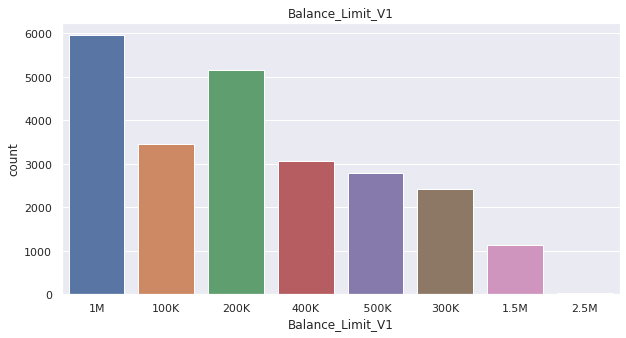

1M       1466
200K     1329
100K      862
400K      749
 500K     692
300K      602
1.5M      292
2.5M        8
Name: Balance_Limit_V1, dtype: int64


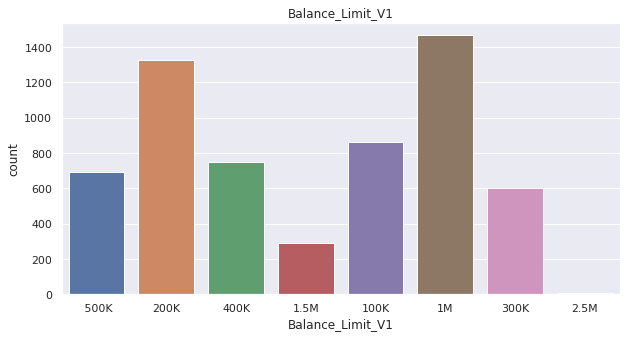

In [231]:
plot_count('Balance_Limit_V1')
plot_count('Balance_Limit_V1', test)

M    14460
F     9540
Name: Gender, dtype: int64


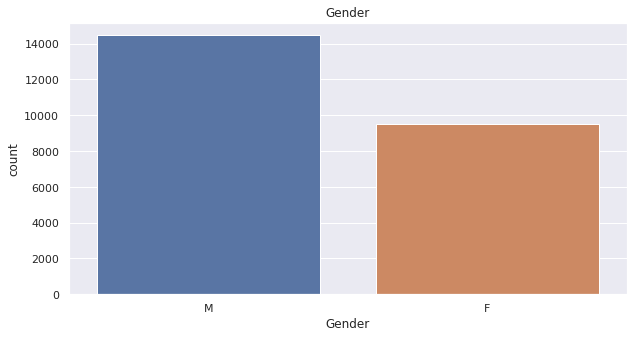

M    3652
F    2348
Name: Gender, dtype: int64


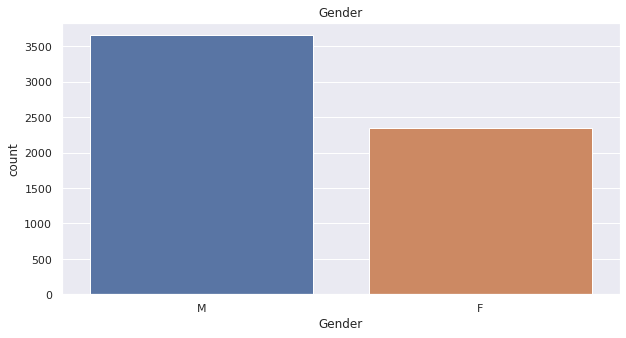

In [232]:
plot_count('Gender')
plot_count('Gender', test)

Other          11597
Graduate        8478
High School     3925
Name: EDUCATION_STATUS, dtype: int64


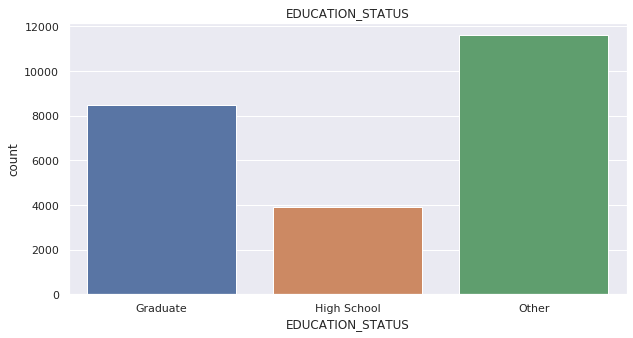

Other          2901
Graduate       2107
High School     992
Name: EDUCATION_STATUS, dtype: int64


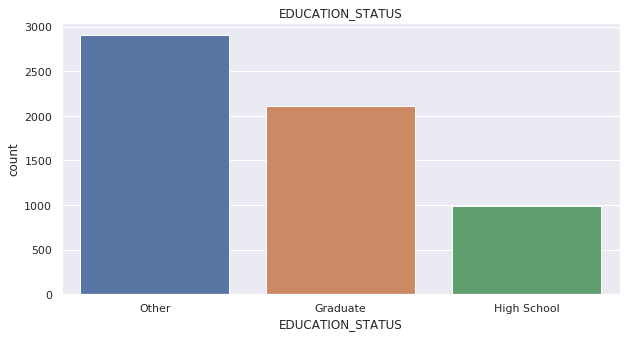

In [233]:
plot_count('EDUCATION_STATUS')
plot_count('EDUCATION_STATUS', test)

Other     13070
Single    10930
Name: MARITAL_STATUS, dtype: int64


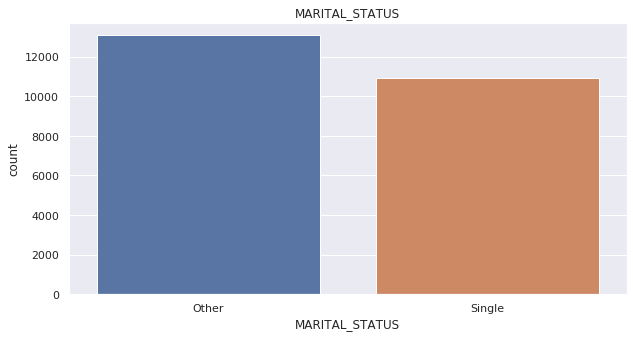

Other     3271
Single    2729
Name: MARITAL_STATUS, dtype: int64


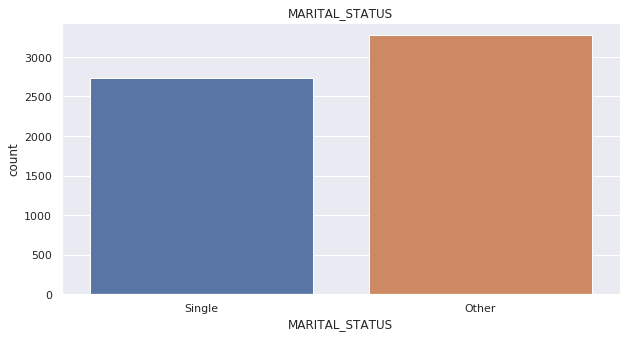

In [234]:
plot_count('MARITAL_STATUS')
plot_count('MARITAL_STATUS', test)

31-45           12124
Less than 30     7638
46-65            4150
More than 65       88
Name: AGE, dtype: int64


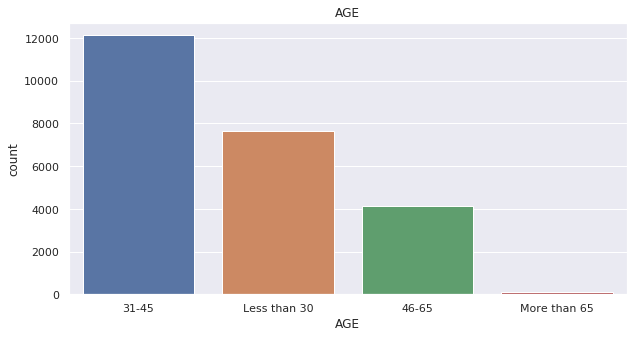

31-45           2972
Less than 30    1980
46-65           1026
More than 65      22
Name: AGE, dtype: int64


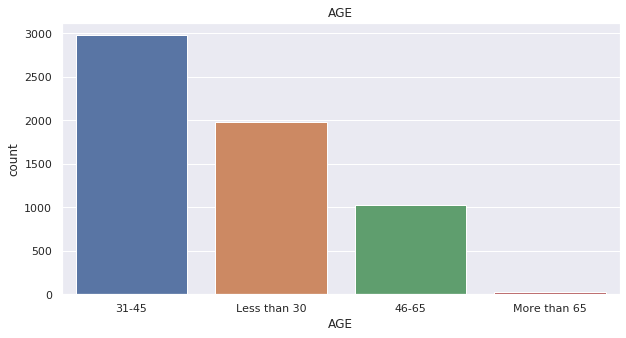

In [235]:
plot_count('AGE')
plot_count('AGE', test)


 0    11788
-1     4534
 1     2956
-2     2205
 2     2140
 3      258
 4       66
 5       23
 8       14
 6       10
 7        6
Name: PAY_JULY, dtype: int64


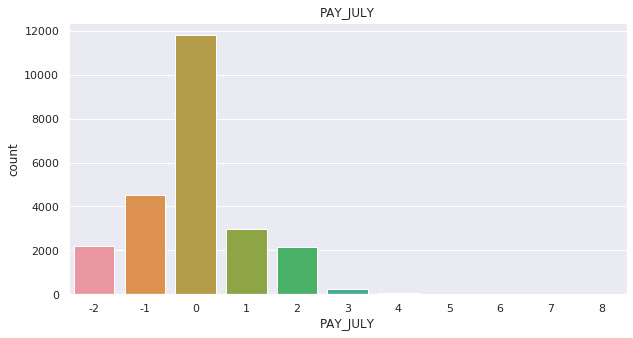

 0    2949
-1    1152
 1     732
-2     554
 2     527
 3      64
 4      10
 8       5
 7       3
 5       3
 6       1
Name: PAY_JULY, dtype: int64


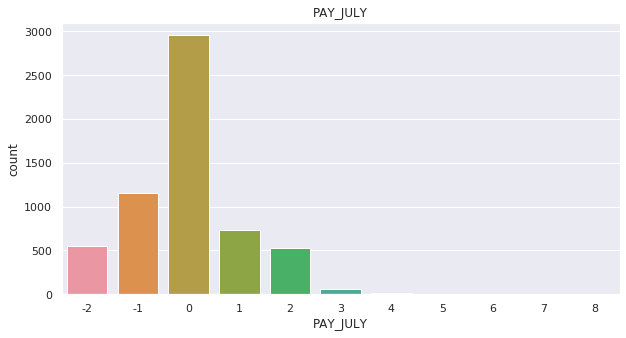

11
11


In [236]:
plot_count('PAY_JULY')
plot_count('PAY_JULY', test)
print(train['PAY_JULY'].nunique())
print(test['PAY_JULY'].nunique())

 0    12562
-1     4847
 2     3150
-2     3014
 3      271
 4       84
 5       24
 1       24
 7       15
 6        8
 8        1
Name: PAY_AUG, dtype: int64


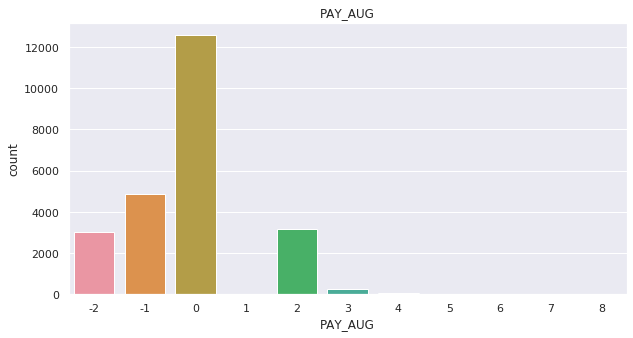

 0    3168
-1    1203
 2     777
-2     768
 3      55
 4      15
 7       5
 6       4
 1       4
 5       1
Name: PAY_AUG, dtype: int64


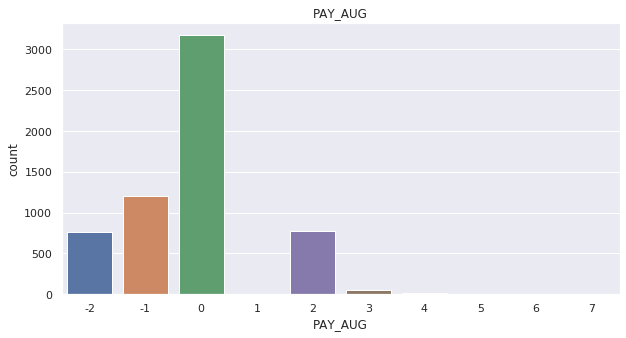

11
10


In [237]:
plot_count('PAY_AUG')
plot_count('PAY_AUG', test)
print(train['PAY_AUG'].nunique())
print(test['PAY_AUG'].nunique())

 0    12609
-1     4730
-2     3240
 2     3097
 3      198
 4       65
 7       21
 6       17
 5       17
 1        4
 8        2
Name: PAY_SEP, dtype: int64


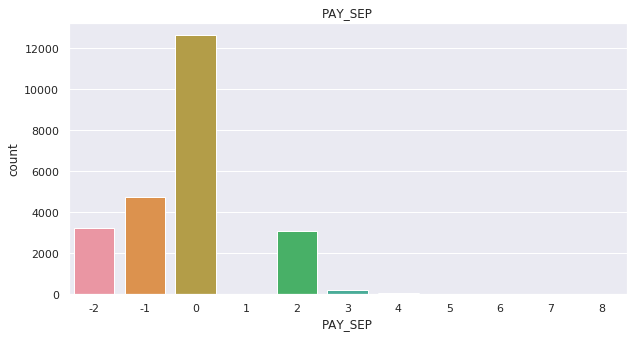

 0    3155
-1    1208
-2     845
 2     722
 3      42
 4      11
 7       6
 6       6
 5       4
 8       1
Name: PAY_SEP, dtype: int64


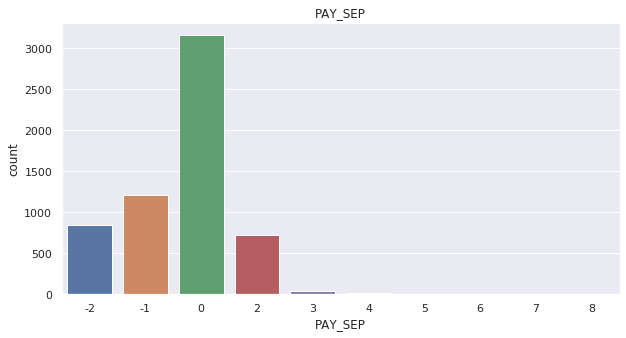

11
10


In [238]:
plot_count('PAY_SEP')
plot_count('PAY_SEP', test)
print(train['PAY_SEP'].nunique())
print(test['PAY_SEP'].nunique())

 0    13199
-1     4514
-2     3453
 2     2548
 3      156
 4       53
 7       42
 5       27
 6        4
 8        2
 1        2
Name: PAY_OCT, dtype: int64


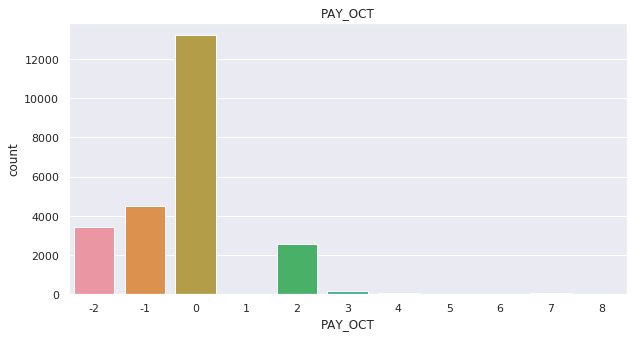

 0    3256
-1    1173
-2     895
 2     611
 3      24
 7      16
 4      16
 5       8
 6       1
Name: PAY_OCT, dtype: int64


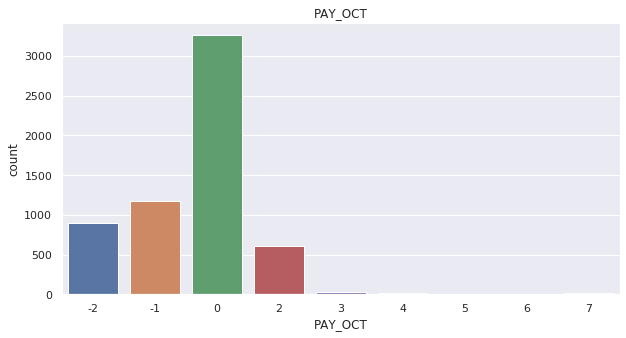

11
9


In [239]:
plot_count('PAY_OCT')
plot_count('PAY_OCT', test)
print(train['PAY_OCT'].nunique())
print(test['PAY_OCT'].nunique())

 0    13581
-1     4415
-2     3605
 2     2124
 3      145
 4       69
 7       44
 5       14
 6        2
 8        1
Name: PAY_NOV, dtype: int64


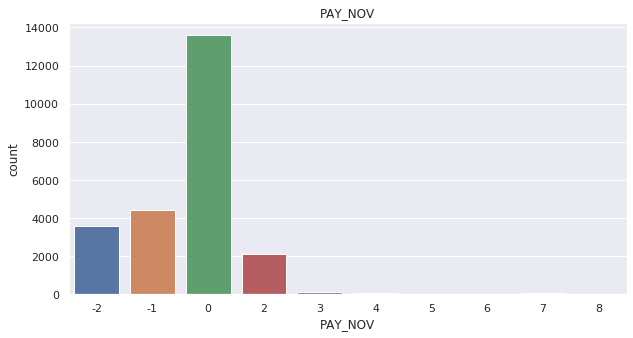

 0    3366
-1    1124
-2     941
 2     502
 3      33
 4      15
 7      14
 5       3
 6       2
Name: PAY_NOV, dtype: int64


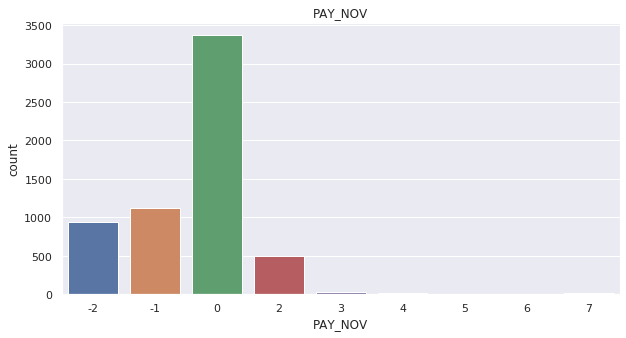

10
9


In [240]:
plot_count('PAY_NOV')
plot_count('PAY_NOV', test)
print(train['PAY_NOV'].nunique())
print(test['PAY_NOV'].nunique())

 0    13045
-1     4591
-2     3885
 2     2231
 3      148
 4       39
 7       34
 6       16
 5        9
 8        2
Name: PAY_DEC, dtype: int64


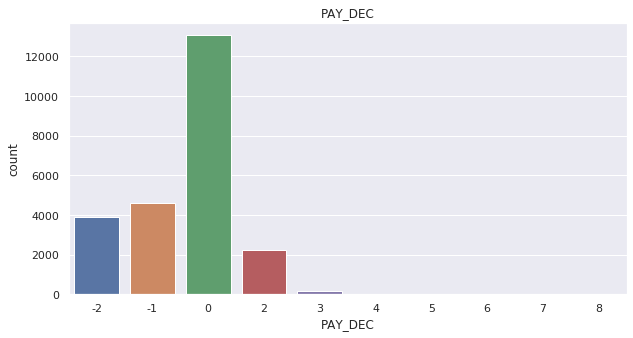

 0    3241
-1    1149
-2    1010
 2     535
 3      36
 7      12
 4      10
 5       4
 6       3
Name: PAY_DEC, dtype: int64


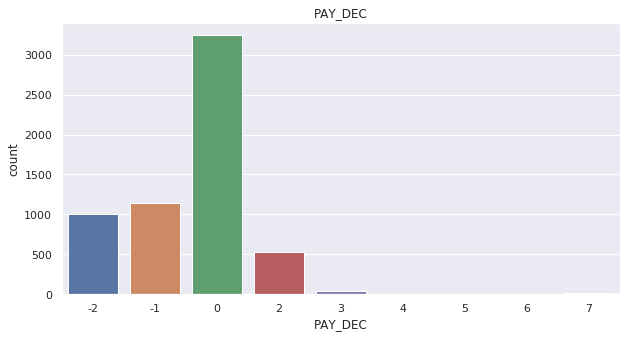

10
9


In [241]:
plot_count('PAY_DEC')
plot_count('PAY_DEC', test)
print(train['PAY_DEC'].nunique())
print(test['PAY_DEC'].nunique())

0    18670
1     5330
Name: NEXT_MONTH_DEFAULT, dtype: int64


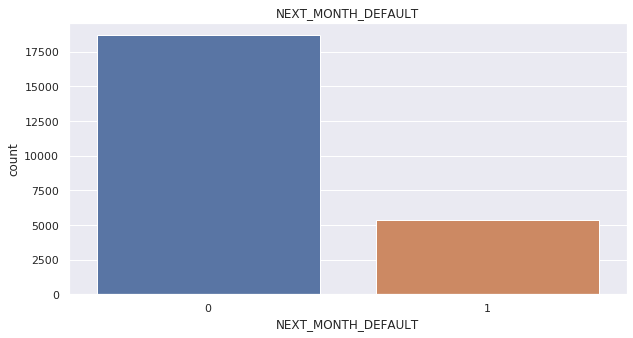

In [242]:
plot_count('NEXT_MONTH_DEFAULT')

## Explore Continuous Data

In [243]:
basic_describe(due_features)

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC
count,24000.00,24000.00,24000.00,24000.00,24000.00,24000.00
mean,118869.73,114072.73,109243.53,100357.26,93776.99,90340.68
std,171042.42,165241.39,161473.65,149007.08,141738.94,138723.70
min,-382490.00,-161185.00,-142079.00,-392700.00,-187882.00,-784483.00
25%,8246.25,6968.75,6238.50,5429.00,4179.75,2913.00
50%,51568.50,48717.00,46411.50,44105.00,41863.00,39409.00
75%,156274.50,148905.00,140162.25,126975.00,116926.25,114435.25
max,2228020.00,2272881.00,3844046.00,2059564.00,2141765.00,2221444.00


**A negative sign before the amount due in your credit card statement means that you have overpaid the due amount on your credit card. This amount would be adjusted in your next credit card bill.**

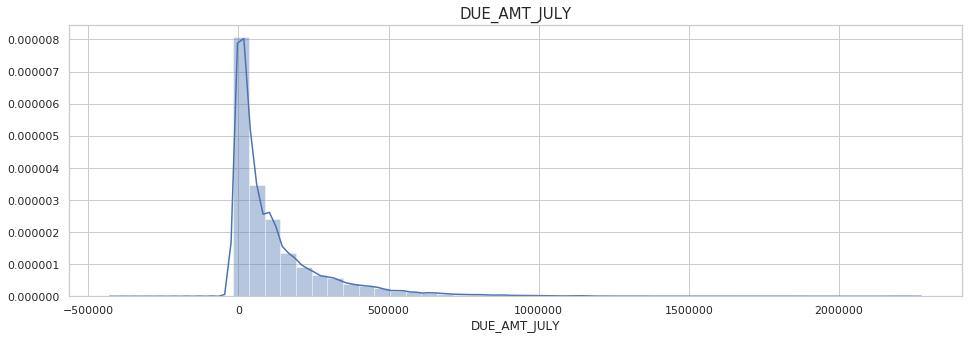

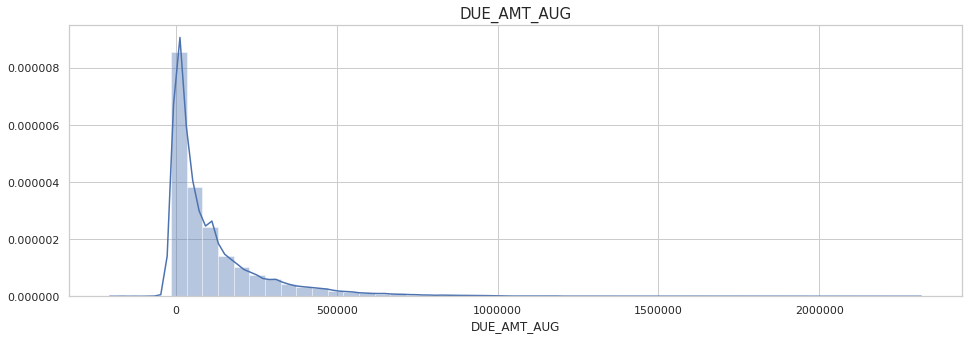

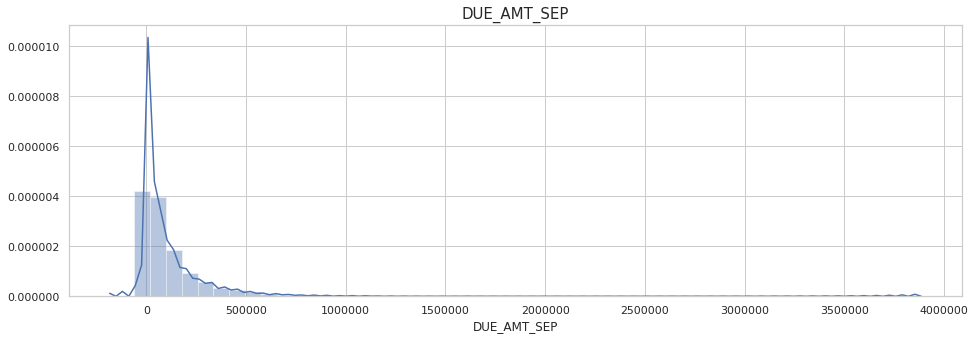

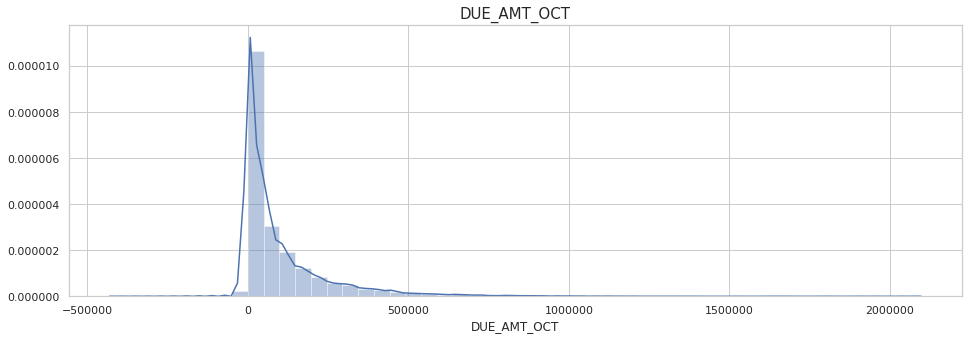

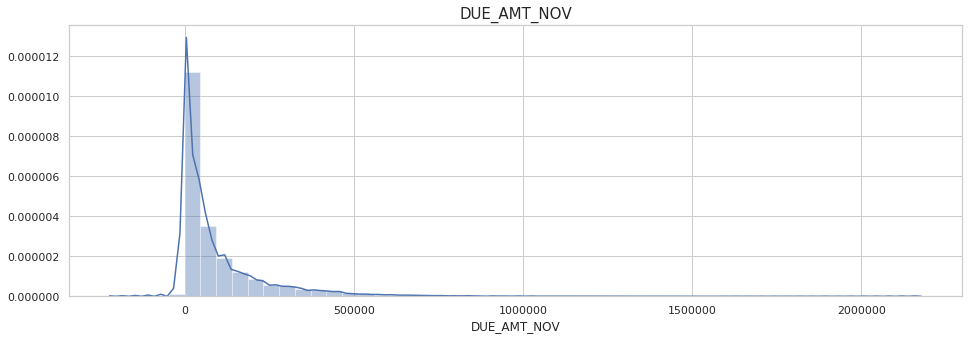

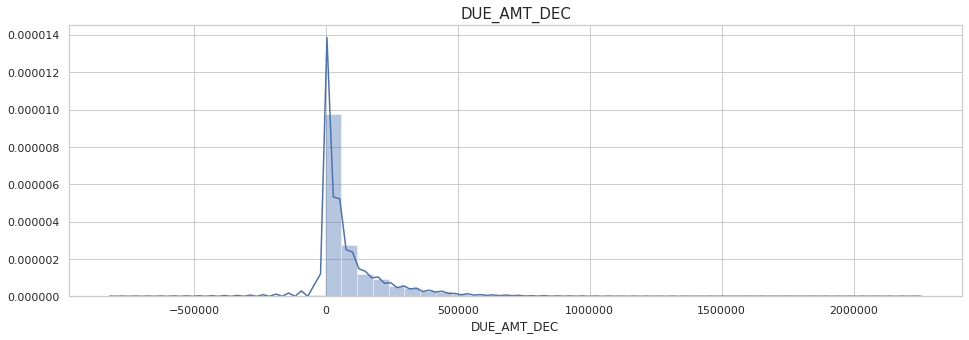

In [244]:
for feature in due_features:
  draw_distplot(feature)

In [245]:
basic_describe(paid_features)

,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC
count,24000.00,24000.00,24000.00,24000.00,24000.00,24000.00
mean,13306.48,13866.75,12093.12,11225.27,11174.74,12301.22
std,39357.42,56485.88,40659.24,36246.93,36040.82,42338.48
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,2310.00,1956.00,901.00,693.00,610.00,307.00
50%,4920.00,4646.50,4197.00,3465.00,3465.00,3465.00
75%,11605.00,11550.00,10626.00,9360.00,9411.50,9252.50
max,2017905.00,3890638.00,2069852.00,1434510.00,965557.00,1221218.00


In [246]:
"for feature in paid_features:
  draw_distplot(feature)

SyntaxError: ignored

# Feature Engineering

### Categorical Variable Preprocessing

In [0]:
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [0]:
# le = LabelEncoder()

# for feature in cat_features:
#   le.fit(train[feature])
#   train[feature] = le.transform(train[feature])
#   test[feature] = le.transform(test[feature])

In [251]:
print(train[cat_features].nunique())
print("******************")
print(test[cat_features].nunique())

Balance_Limit_V1     8
Gender               2
EDUCATION_STATUS     3
MARITAL_STATUS       2
AGE                  4
PAY_JULY            11
PAY_AUG             11
PAY_SEP             11
PAY_OCT             11
PAY_NOV             10
PAY_DEC             10
dtype: int64
******************
Balance_Limit_V1     8
Gender               2
EDUCATION_STATUS     3
MARITAL_STATUS       2
AGE                  4
PAY_JULY            11
PAY_AUG             10
PAY_SEP             10
PAY_OCT              9
PAY_NOV              9
PAY_DEC              9
dtype: int64


In [0]:
train_test = pd.concat([train, test], axis=0)

In [265]:
train_test.head()

,AGE,Balance_Limit_V1,Client_ID,DUE_AMT_AUG,DUE_AMT_DEC,DUE_AMT_JULY,DUE_AMT_NOV,DUE_AMT_OCT,DUE_AMT_SEP,EDUCATION_STATUS,Gender,MARITAL_STATUS,NEXT_MONTH_DEFAULT,PAID_AMT_AUG,PAID_AMT_DEC,PAID_AMT_JULY,PAID_AMT_NOV,PAID_AMT_OCT,PAID_AMT_SEP,PAY_AUG,PAY_DEC,PAY_JULY,PAY_NOV,PAY_OCT,PAY_SEP
0,31-45,1M,A2,3389,-13982,3248,162772,39418,6004,Graduate,M,Other,0.00,6004,538165,3437,0,162772,39418,-1,-1,-1,-1,-1,-1
1,Less than 30,1M,A3,151818,124590,353351,80811,43530,26948,High School,F,Other,0.00,46200,33666,151818,942,80811,43530,-1,0,0,-1,-1,-1
2,31-45,100K,A4,16082,0,16681,0,0,15477,High School,F,Single,1.00,0,0,0,0,0,0,3,-2,4,-2,2,2
3,31-45,200K,A5,92848,102740,90457,100353,97309,95193,Graduate,F,Single,1.00,3890,3918,3855,4049,4620,3696,0,0,2,0,0,0
4,31-45,1M,A6,419466,453899,429556,445271,435354,429785,Graduate,F,Other,0.00,20790,17325,0,16401,17325,16170,2,0,2,0,0,0


In [266]:
train_test.tail()

,AGE,Balance_Limit_V1,Client_ID,DUE_AMT_AUG,DUE_AMT_DEC,DUE_AMT_JULY,DUE_AMT_NOV,DUE_AMT_OCT,DUE_AMT_SEP,EDUCATION_STATUS,Gender,MARITAL_STATUS,NEXT_MONTH_DEFAULT,PAID_AMT_AUG,PAID_AMT_DEC,PAID_AMT_JULY,PAID_AMT_NOV,PAID_AMT_OCT,PAID_AMT_SEP,PAY_AUG,PAY_DEC,PAY_JULY,PAY_NOV,PAY_OCT,PAY_SEP
5995,31-45,1M,A11104,515604,461148,512728,475236,470226,522982,High School,M,Other,nan,23100,16170,21945,18457,17325,16401,0,0,0,0,0,0
5996,31-45,1.5M,A2781,1155,-7,1610,1065,0,0,Graduate,F,Single,nan,0,0,1167,7,1065,0,-1,-1,-1,-1,-2,-1
5997,31-45,300K,A1767,106422,93403,188646,87965,85075,79508,Other,M,Single,nan,4620,11550,5683,6930,4620,6930,0,0,0,0,0,0
5998,46-65,200K,A1850,1677,34650,1677,34650,34650,35574,High School,M,Single,nan,35574,231,0,0,0,0,2,0,-1,0,0,-1
5999,31-45,1.5M,A26905,396315,354234,359944,322839,351963,426846,Other,F,Single,nan,46757,46285,46200,46549,46244,46556,0,0,0,0,0,0


In [267]:
train_test.shape

(30000, 25)

In [0]:
for feature in pay_int:
  train_test.loc[train_test[feature] <= 0,feature]=0

In [276]:
train_test['delayed_months'] = train_test[pay_int].sum(axis=1)
train_test.head()

,AGE,Balance_Limit_V1,Client_ID,DUE_AMT_AUG,DUE_AMT_DEC,DUE_AMT_JULY,DUE_AMT_NOV,DUE_AMT_OCT,DUE_AMT_SEP,EDUCATION_STATUS,Gender,MARITAL_STATUS,NEXT_MONTH_DEFAULT,PAID_AMT_AUG,PAID_AMT_DEC,PAID_AMT_JULY,PAID_AMT_NOV,PAID_AMT_OCT,PAID_AMT_SEP,PAY_AUG,PAY_DEC,PAY_JULY,PAY_NOV,PAY_OCT,PAY_SEP,delayed_months
0,31-45,1M,A2,3389,-13982,3248,162772,39418,6004,Graduate,M,Other,0.00,6004,538165,3437,0,162772,39418,0,0,0,0,0,0,0
1,Less than 30,1M,A3,151818,124590,353351,80811,43530,26948,High School,F,Other,0.00,46200,33666,151818,942,80811,43530,0,0,0,0,0,0,0
2,31-45,100K,A4,16082,0,16681,0,0,15477,High School,F,Single,1.00,0,0,0,0,0,0,3,0,4,0,2,2,11
3,31-45,200K,A5,92848,102740,90457,100353,97309,95193,Graduate,F,Single,1.00,3890,3918,3855,4049,4620,3696,0,0,2,0,0,0,2
4,31-45,1M,A6,419466,453899,429556,445271,435354,429785,Graduate,F,Other,0.00,20790,17325,0,16401,17325,16170,2,0,2,0,0,0,4


In [0]:
numerical_features = due_features+ paid_features+['delayed_months']

In [281]:
numerical_features

['DUE_AMT_JULY',
 'DUE_AMT_AUG',
 'DUE_AMT_SEP',
 'DUE_AMT_OCT',
 'DUE_AMT_NOV',
 'DUE_AMT_DEC',
 'PAID_AMT_JULY',
 'PAID_AMT_AUG',
 'PAID_AMT_SEP',
 'PAID_AMT_OCT',
 'PAID_AMT_NOV',
 'PAID_AMT_DEC',
 'delayed_months']

In [0]:
train_test = pd.get_dummies(data=train_test, columns=cat_features, drop_first=True)

In [283]:
test_processed = train_test[train_test['NEXT_MONTH_DEFAULT'].isna()]
test_processed.shape

(6000, 35)

In [284]:
train_processed = train_test[train_test['NEXT_MONTH_DEFAULT'].notna()]
train_processed.shape

(24000, 35)

### Continuous Variable Preprocessing

In [285]:
basic_describe(due_features, train_processed)

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC
count,24000.00,24000.00,24000.00,24000.00,24000.00,24000.00
mean,118869.73,114072.73,109243.53,100357.26,93776.99,90340.68
std,171042.42,165241.39,161473.65,149007.08,141738.94,138723.70
min,-382490.00,-161185.00,-142079.00,-392700.00,-187882.00,-784483.00
25%,8246.25,6968.75,6238.50,5429.00,4179.75,2913.00
50%,51568.50,48717.00,46411.50,44105.00,41863.00,39409.00
75%,156274.50,148905.00,140162.25,126975.00,116926.25,114435.25
max,2228020.00,2272881.00,3844046.00,2059564.00,2141765.00,2221444.00


In [286]:
basic_describe(due_features, test_processed)

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC
count,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00
mean,116150.50,111727.29,106027.90,98258.05,90488.77,87606.15
std,166267.25,161048.70,154972.09,147005.70,135106.32,132843.72
min,-357988.00,-20707.00,-363280.00,-63502.00,-141769.00,-54678.00
25%,8110.00,6339.00,5890.25,5274.25,3643.00,2829.75
50%,52273.00,49926.00,46391.50,43713.50,41711.50,39554.00
75%,149199.00,141982.75,134357.25,119462.75,112801.25,111241.75
max,1436240.00,1334443.00,1337423.00,1452295.00,1211168.00,1147610.00


In [0]:
for feature in due_features:
  scaler = MinMaxScaler(feature_range=(-1,1)).fit(np.array(train_processed[feature]).reshape(-1, 1))
  train_processed[feature] = scaler.transform(np.array(train_processed[feature]).reshape(-1, 1))
  test_processed[feature] = scaler.transform(np.array(test_processed[feature]).reshape(-1, 1))

In [288]:
basic_describe(due_features, train_processed)

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC
count,24000.00,24000.00,24000.00,24000.00,24000.00,24000.00
mean,-0.62,-0.77,-0.87,-0.60,-0.76,-0.42
std,0.13,0.14,0.08,0.12,0.12,0.09
min,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
25%,-0.70,-0.86,-0.93,-0.68,-0.84,-0.48
50%,-0.67,-0.83,-0.91,-0.64,-0.80,-0.45
75%,-0.59,-0.75,-0.86,-0.58,-0.74,-0.40
max,1.00,1.00,1.00,1.00,1.00,1.00


In [289]:
basic_describe(due_features, test_processed)

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC
count,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00
mean,-0.62,-0.78,-0.88,-0.60,-0.76,-0.42
std,0.13,0.13,0.08,0.12,0.12,0.09
min,-0.98,-0.88,-1.11,-0.73,-0.96,-0.51
25%,-0.70,-0.86,-0.93,-0.68,-0.84,-0.48
50%,-0.67,-0.83,-0.91,-0.64,-0.80,-0.45
75%,-0.59,-0.75,-0.86,-0.58,-0.74,-0.40
max,0.39,0.23,-0.26,0.50,0.20,0.29


In [290]:
basic_describe(paid_features, train_processed)

,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC
count,24000.00,24000.00,24000.00,24000.00,24000.00,24000.00
mean,13306.48,13866.75,12093.12,11225.27,11174.74,12301.22
std,39357.42,56485.88,40659.24,36246.93,36040.82,42338.48
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,2310.00,1956.00,901.00,693.00,610.00,307.00
50%,4920.00,4646.50,4197.00,3465.00,3465.00,3465.00
75%,11605.00,11550.00,10626.00,9360.00,9411.50,9252.50
max,2017905.00,3890638.00,2069852.00,1434510.00,965557.00,1221218.00


In [291]:
basic_describe(paid_features, test_processed)

,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC
count,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00
mean,12188.47,12922.45,11984.18,10840.15,10734.02,11034.23
std,33507.68,37431.95,40726.69,35956.84,32127.88,35507.97
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,1931.00,1830.00,903.00,617.25,422.25,164.25
50%,4689.00,4622.00,4090.00,3465.00,3465.00,3456.00
75%,11550.00,11550.00,9934.25,9240.00,9240.00,9240.00
max,704123.00,795719.00,1174009.00,924106.00,985282.00,553014.00


In [0]:
for feature in paid_features:
  scaler = MinMaxScaler().fit(np.array(train_processed[feature]).reshape(-1, 1))
  train_processed[feature] = scaler.transform(np.array(train_processed[feature]).reshape(-1, 1))
  test_processed[feature] = scaler.transform(np.array(test_processed[feature]).reshape(-1, 1))

In [293]:
basic_describe(paid_features, train_processed)

,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC
count,24000.00,24000.00,24000.00,24000.00,24000.00,24000.00
mean,0.01,0.00,0.01,0.01,0.01,0.01
std,0.02,0.01,0.02,0.03,0.04,0.03
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.01,0.00,0.01,0.01,0.01,0.01
max,1.00,1.00,1.00,1.00,1.00,1.00


In [294]:
basic_describe(paid_features, test_processed)

,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC
count,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00
mean,0.01,0.00,0.01,0.01,0.01,0.01
std,0.02,0.01,0.02,0.03,0.03,0.03
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.01,0.00,0.00,0.01,0.01,0.01
max,0.35,0.20,0.57,0.64,1.02,0.45


In [0]:
train_processed.drop(columns='Client_ID',inplace=True)

# Modelling

In [0]:
X=train_processed.drop(columns='NEXT_MONTH_DEFAULT')
y=train_processed['NEXT_MONTH_DEFAULT'].astype("int32")

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, shuffle=True,stratify=y)

In [0]:
# n_estimators = [100,200,300,500,800]
# max_depth = [5, 8, 15, 30]

# param_dict = {'n_estimators':n_estimators, 'max_depth':max_depth}

# forest = RandomForestClassifier(random_state=1)
# grid = GridSearchCV(forest, param_grid=param_dict, cv=10, verbose=1, n_jobs=-1)
# best_forest = grid.fit(X_train,y_train)

In [0]:
# best_forest.score(X_test, y_test)

In [0]:
# from sklearn.metrics import f1_score
# y_pred = best_forest.predict(X_test)

# print(f1_score(y_test, y_pred, average='micro'))
# print(f1_score(y_test, y_pred, average='macro'))
# print(f1_score(y_test, y_pred, average='weighted'))

In [0]:
import lightgbm as lgb

In [302]:
train_set = lgb.Dataset(X_train, label=y_train)

valid_set = lgb.Dataset(X_test, label=y_test)

evals_result = {} 

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

grid_param = {"learning_rate": [0.07, 0.05],
         "n_estimators" : [8, 16, 32, 64],
         "num_leaves" : [20, 24, 27],
         "lambda_l2" : [1.2, 1.5, 1],
         "colsample_bytree" : [0.7, 0.64, 0.67],
         "bagging_fraction" : [0.7, 0.64, 0.67] 
         }
    
model = lgb.LGBMClassifier(boosting_type='gbdt',
                           objective = "binary",
                           metric = 'binary',
                           n_jobs=-1,
                           silent=True,
                           max_depth = params['max_depth'],
                           max_bin = params['max_bin'],
                           subsample_for_bin = params['subsample_for_bin'],
                           subsample = params['subsample'],
                           subsample_freq = params['subsample_freq'],
                           min_split_gain = params['min_split_gain'],
                           min_child_weight = params['min_child_weight'],
                           min_child_samples = params['min_child_samples'],
                           scale_pos_weight = params['scale_pos_weight']
                           )

grid2 = GridSearchCV(model, grid_param, verbose=2, cv=5, n_jobs=-1)
grid2.fit(X_train, y_train)
# del train_set,valid_set

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=512,
                                      max_depth=-1, metric='binary',
                                      min_child_samples=5, min_child_weight=1,
                                      min_split_gain=0.5, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0....
                                      scale_pos_weight=1, silent=True,
                                      subsample=1, subsample_for_bin=200,
                                      subsample_freq=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'bag

In [0]:
model_trained = grid2.best_estimator_

In [0]:
def plot_feature(data):
  sns.set(style='darkgrid')
  f, ax = plt.subplots(figsize=(6, 15))
  sns.barplot(x="counts", y="feature", data=data.sort_values(by=['counts']),
            label="Feature Important", color="b")
  plt.show()

In [305]:
data=pd.DataFrame({"feature":X_train.columns,"counts":model_trained.feature_importance()},columns=["feature","counts"])

AttributeError: ignored

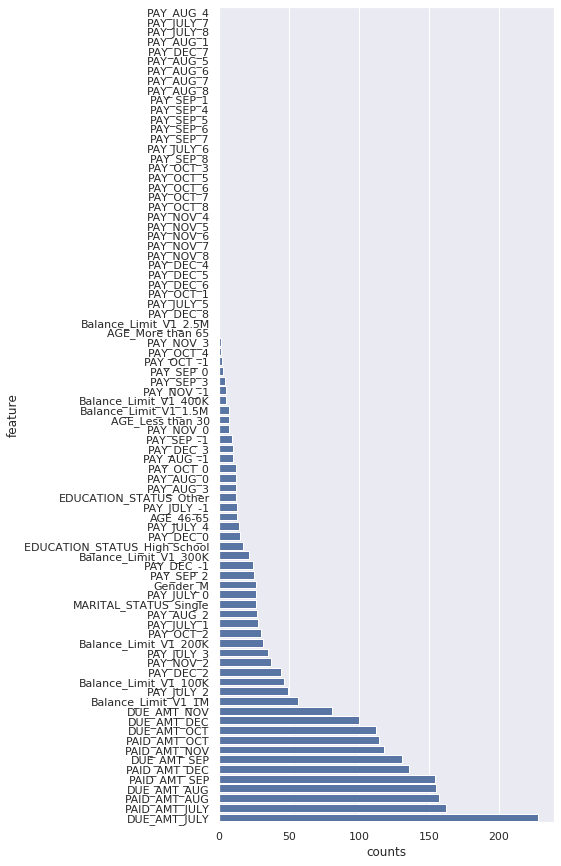

In [306]:
plot_feature(data)

In [308]:
y_pred2 = grid2.best_estimator_.predict(X_test)
y_pred2

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [0]:
# y_pred2 = np.where(y_pred2>0.5, 1, 0)

In [310]:
print(f1_score(y_test, y_pred2, average='micro'))
print(f1_score(y_test, y_pred2, average='macro'))
print(f1_score(y_test, y_pred2, average='weighted'))

0.825
0.6937993456176094
0.8052071578048207


In [167]:
print(f1_score(y_test, y_pred2, average='micro'))
print(f1_score(y_test, y_pred2, average='macro'))
print(f1_score(y_test, y_pred2, average='weighted'))

0.818
0.683421001363725
0.7955701668939543


In [311]:
test_processed.head()

,Client_ID,DUE_AMT_AUG,DUE_AMT_DEC,DUE_AMT_JULY,DUE_AMT_NOV,DUE_AMT_OCT,DUE_AMT_SEP,NEXT_MONTH_DEFAULT,PAID_AMT_AUG,PAID_AMT_DEC,PAID_AMT_JULY,PAID_AMT_NOV,PAID_AMT_OCT,PAID_AMT_SEP,PAY_AUG,PAY_DEC,PAY_JULY,PAY_NOV,PAY_OCT,PAY_SEP,delayed_months,Balance_Limit_V1_1.5M,Balance_Limit_V1_100K,Balance_Limit_V1_1M,Balance_Limit_V1_2.5M,Balance_Limit_V1_200K,Balance_Limit_V1_300K,Balance_Limit_V1_400K,Gender_M,EDUCATION_STATUS_High School,EDUCATION_STATUS_Other,MARITAL_STATUS_Single,AGE_46-65,AGE_Less than 30,AGE_More than 65
0,A20170,-0.70,-0.24,-0.56,-0.54,-0.43,-0.86,nan,0.00,0.01,0.01,0.02,0.04,0.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
1,A16887,-0.79,-0.41,-0.64,-0.76,-0.60,-0.88,nan,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
2,A3430,-0.86,-0.48,-0.70,-0.83,-0.67,-0.92,nan,0.00,0.03,0.00,0.00,0.00,0.00,0,0,0,0,0,2,2,0,0,0,0,0,0,1,1,0,1,0,0,1,0
3,A3696,-0.86,-0.48,-0.71,-0.84,-0.68,-0.93,nan,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0
4,A20474,-0.87,-0.48,-0.64,-0.84,-0.68,-0.93,nan,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [0]:
test_processed_clinet=test_processed['Client_ID']

In [0]:
test_data=test_processed.drop(columns=['Client_ID','NEXT_MONTH_DEFAULT'])

In [315]:
X_train.shape

(19200, 33)

In [0]:
y_pred_test = grid2.best_estimator_.predict(test_data)

In [0]:
test_processed_clinet = test_processed_clinet.to_numpy()

In [0]:
data = {'Client_ID': test_processed_clinet, 'NEXT_MONTH_DEFAULT': y_pred_test}

In [323]:
results = pd.DataFrame(data)
results.head()

,Client_ID,NEXT_MONTH_DEFAULT
0,A20170,0
1,A16887,0
2,A3430,0
3,A3696,0
4,A20474,0


In [0]:
results.to_csv("results.csv", index=False)